# Data Preparation

__In this notebook, we will go through the steps followed in order to prepare the data required for our application. <br>
The data used in this user study is provided by the well-known online recipe website [allrecipes](https://www.allrecipes.com/). <br>
The data is meant to use for research purposes. <br>
In a nutshell, the steps are :__
  1. __Read the csv file of each category and add categpry column to DF__
  2. __Extract the recipes that has image, as images will be used in our study__
  3. __Compute Fsa and Nutri score for each recipe as main decision factor for healthiness of each recipe__
  4. __Split recipies into healthy and unhealthy ones based on Fsa threshold (8)__
  5. __Prepare rating matrices for each category, to be usd in recommendation generation phase__
  6. __save the data__
  7. __Optional: Push the data into Database__<br>
For more information about the dataset: __ayoub.majjodi@uib.no__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set(font_scale = 2)
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [96]:
# read data files
def read_data(data):
    sep = '\t'
    file = data + '.csv'
    if data == 'images':
        sep = ';'
    row_data = pd.read_csv(file, sep = sep)
    return row_data
# size of each dataset
def size(data, name):
    return   print('number of recipes in {0}: {1}'.format( name, len(data)))

In [97]:
# read each category
bbq = read_data('bbq')
fruit_veg = read_data('fruits_vegetables')
meat_poultry = read_data('Meat_poultry')
pasta_noodles = read_data('pasta_and_noodles')
salad = read_data('salad')
seafood = read_data('Seafood')
soups_chili = read_data('soups_stews_and_chili')
images = read_data('images')

In [98]:
size(bbq, 'bbq'), size(fruit_veg, 'fruit_veg')
size(meat_poultry, 'meat_poultry'), size(pasta_noodles, 'pasta_noodles')
size(salad, 'salad'), size(seafood, 'seafood')
size(soups_chili, 'soups_chili'), size(images, 'images')

number of recipes in bbq: 1682
number of recipes in fruit_veg: 19574
number of recipes in meat_poultry: 12672
number of recipes in pasta_noodles: 2692
number of recipes in salad: 3031
number of recipes in seafood: 3237
number of recipes in soups_chili: 3605
number of recipes in images: 162985


(None, None)

## Add category column to the data

In [99]:
bbq['category'] = 'Barbecue'
fruit_veg['category'] = 'Fruits and Vegetables'
meat_poultry['category'] = 'Meat and Poultry'
salad['category'] = 'Salad'
pasta_noodles['category'] = 'Pasta and Noodles'
seafood['category'] = 'Seafood'
soups_chili['category'] = 'Soups and Chili'

# Extract recipes with images

In [100]:
def recipe_with_image(data, images):
    images = images.drop_duplicates(subset=['recipe_id'])
    data_with_image = pd.merge(data, images, left_on=  'URL',
                   right_on= 'recipe_id', how='inner')
    if data_with_image.isnull().values.any():
           data_with_image= data_with_image.dropna()
    data_with_image =  data_with_image.drop(['cook_id','recipe_id','date_added'], axis=1)
    data_with_image['id'] = range(0, len(data_with_image))
    first_column = data_with_image.pop('id')
    data_with_image.insert(0,'id',first_column)
    return data_with_image

In [101]:
final_bbq = recipe_with_image(bbq, images)
final_fruit =  recipe_with_image(fruit_veg, images)
final_meat_poultry =  recipe_with_image(meat_poultry, images)
final_salad = recipe_with_image(salad, images)
final_pasta_noodles = recipe_with_image(pasta_noodles, images)
final_seafood = recipe_with_image(seafood, images)
final_soups_chili = recipe_with_image(soups_chili, images)

In [102]:
size(final_bbq, 'bbq'), size(final_fruit, 'fruit_veg')
size(final_meat_poultry, 'meat_poultry'), size(final_pasta_noodles, 'pasta_noodles')
size(final_salad, 'salad'), size(final_seafood, 'seafood')
size(final_soups_chili, 'soups_chili')

number of recipes in bbq: 1200
number of recipes in fruit_veg: 12916
number of recipes in meat_poultry: 8375
number of recipes in pasta_noodles: 1810
number of recipes in salad: 2062
number of recipes in seafood: 1931
number of recipes in soups_chili: 2199


In [103]:
final_bbq.to_csv('./Results/bbq.csv', index=False)
final_fruit.to_csv('./Results/fruit.csv', index=False)
final_meat_poultry.to_csv('./Results/meat_poultry.csv', index=False)
final_pasta_noodles.to_csv('./Results/pasta_noodles.csv',index=False)
final_salad.to_csv('./Results/salad.csv',index=False)
final_seafood.to_csv('./Results/seafood.csv',index=False)
final_soups_chili.to_csv('./Results/soup_chili.csv',index=False)

# Concat recipes in one DF

In [104]:
recipes = [final_bbq,final_fruit,final_meat_poultry,final_pasta_noodles,final_salad
          ,final_seafood,final_soups_chili]
final_recipes = pd.concat(recipes)
final_recipes.to_csv('./Results/final_recipes.csv', index=False)

In [105]:
final_recipes['category'].value_counts()

Fruits and Vegetables    12916
Meat and Poultry          8375
Soups and Chili           2199
Salad                     2062
Seafood                   1931
Pasta and Noodles         1810
Barbecue                  1200
Name: category, dtype: int64

# Preapre nutrients for 100g and Nuri/Fsa score

In [560]:
# read the data
final_recipes = pd.read_csv('./Results/final_recipes.csv')
final_recipes.columns

Index(['id', 'URL', 'Name', 'Fiber (g)', 'Sodium (g)', 'Carbohydrates (g)',
       'Fat (g)', 'Protein (g)', 'Sugar (g)', 'Saturated Fat (g)', 'Size (g)',
       'Servings', 'Calories (kCal)', 'Average Rating', 'Average Sentiment',
       'Number of Ratings', 'Number of Bookmarks', 'Year of Publishing',
       'category', 'image_link'],
      dtype='object')

In [561]:
final_recipes['fiber_100g'] = (final_recipes['Servings'] * final_recipes['Fiber (g)'] * 100) / final_recipes['Size (g)']
final_recipes['fat_100g'] = (final_recipes['Servings'] * final_recipes['Fat (g)'] * 100) / final_recipes['Size (g)']
final_recipes['sugar_100g'] = (final_recipes['Servings'] * final_recipes['Sugar (g)'] * 100) / final_recipes['Size (g)']
final_recipes['saturated_100g'] = (final_recipes['Servings'] * final_recipes['Saturated Fat (g)'] * 100) / final_recipes['Size (g)']
final_recipes['sodium_100mg'] = ((final_recipes['Servings'] * final_recipes['Sodium (g)'] * 100) / final_recipes['Size (g)'])*1000
final_recipes['carbohydrates_100g'] = (final_recipes['Servings'] * final_recipes['Carbohydrates (g)'] * 100) / final_recipes['Size (g)']
final_recipes['protein_100g'] = (final_recipes['Servings'] * final_recipes['Protein (g)'] * 100) / final_recipes['Size (g)']
final_recipes['kj_100g'] = ((final_recipes['Servings'] * final_recipes['Calories (kCal)'] * 100) / final_recipes['Size (g)'])*4.1868
final_recipes['Salt (g)'] = final_recipes['Sodium (g)'] * 2.54
final_recipes['salt_100g'] = (final_recipes['Servings'] * final_recipes['Salt (g)'] * 100) / final_recipes['Size (g)']

In [562]:
# rename columns to match ones in database
final_recipes = final_recipes.rename(columns={'Fiber (g)':'fiber_g','Sodium (g)':'sodium_g','Carbohydrates (g)':'carbohydrates_g',
                                                           'Fat (g)':'fat_g','Protein (g)':'protein_g','Sugar (g)':'sugar_g',
                                                           'Saturated Fat (g)':'saturate_g','Size (g)':'size_g',
                                                           'Calories (kCal)':'calories_kCal', 'Salt (g)':'salt_g', 'Number of Ratings':'NumberRatings'})


# Fsa Score based on :

- compute the FSA score and Nutri score:

- `https://www.food.gov.uk/sites/default/files/media/document/fop-guidance_0.pdf`

- `https://www.santepubliquefrance.fr/content/download/150263/file/2021_07_21_QR_scientifique_et_technique_V41_EN.pdf <br>`
- Paper: __Development of a new front-of-pack nutrition label in France: the five-colour Nutri-Score__

In [563]:
for i in final_recipes.index:
    fat_count = satfat_count = sugar_count = salt_count = 2
    if final_recipes.at[i,'fat_100g'] <= 3:
        fat_count = 1
    if final_recipes.at[i, 'fat_g'] > 21 or final_recipes.at[i, 'fat_100g'] > 17.5: # here the mistake :) > 17.5
        fat_count = 3
    if final_recipes.at[i,'saturated_100g'] <= 1.5:
        satfat_count = 1
    if final_recipes.at[i, 'saturate_g'] > 6 or final_recipes.at[i,'saturated_100g'] > 5:
        satfat_count = 3
    if final_recipes.at[i, 'sugar_100g'] <= 5:
        sugar_count = 1
    if final_recipes.at[i, 'sugar_100g'] > 22.5 or final_recipes.at[i, 'sugar_g'] > 27:
        sugar_count = 3
    if final_recipes.at[i, 'salt_100g'] <= 0.3:
        salt_count = 1
    if final_recipes.at[i, 'salt_100g'] > 1.5 or final_recipes.at[i, 'salt_g']> 1.8:
        salt_count = 3 
    final_recipes.at[i,'Fsa_new'] = fat_count + satfat_count + sugar_count + salt_count
    final_recipes.at[i, 'fat_count'] = fat_count
    final_recipes.at[i, 'satfat_count'] = satfat_count
    final_recipes.at[i, 'sugar_count'] = sugar_count
    final_recipes.at[i, 'salt_count'] = salt_count

In [564]:
## FSA score distribution
final_recipes['Fsa_new'].value_counts().sort_index()

4.0     1045
5.0     2069
6.0     3801
7.0     3660
8.0     4212
9.0     4477
10.0    5908
11.0     862
12.0     198
Name: Fsa_new, dtype: int64

In [567]:
## Genereate the Nutri-score annotation for a given value
def NutriScore_string(score):
    str_score = ''
    if score in range(-15, 0):
        str_score = 'A'
    if score in range(0,3):
        str_score = 'B'
    if score in range(3,11):
        str_score = 'C'
    if score in range(11,19):
        str_score = 'D'
    if score in range(19,41):
        str_score = 'E'
    return str_score    

In [568]:
# compute nutri- score
for i in final_recipes.index.to_list():
#     print(i)
    # assign a point to enrgyA
    energy = final_recipes.at[i,'kj_100g']
    if energy > 3350:
        kj_point = 10
    else:
        energy_level = energy % 335 # if the rest of is > 335 move to next point
        if energy_level <= 335:
            kj_point = energy // 335
        else:
            kj_point = (energy // 335) + 1
    # assign a point to Sugar
    sugar = final_recipes.at[i, 'sugar_100g']
    if sugar > 45:
        sg_point = 10
    else:
        sg_level = sugar % 4.5
        if sg_level <= 4.5:
            sg_point = sugar // 4.5
        else:
            sg_point = (sugar // 4.5) + 1
    # assign a point to saturated_100g
    sat_fat = final_recipes.at[i, 'saturated_100g']
    if sat_fat > 10:
        sf_point = 10
    else:
        sf_level = sat_fat % 1
        if sf_level <= 1:
            sf_point = sat_fat // 1
        else:
            sf_point = (sat_fat // 1) + 1
    # assign a point to sodium_100mg
    sodium = final_recipes.at[i, 'sodium_100mg']
    if sodium > 900:
        sdm_point = 10
    else:
        sdm_level = sodium % 90
        if sdm_level <= 90:
            sdm_point = sodium // 90
        else:
            sdm_point = (sodium // 90) + 1

    N_point = kj_point + sg_point + sf_point + sdm_point # negative point

    # positive point 
    fiber = final_recipes.at[i, 'fiber_100g']
    protien = final_recipes.at[i, 'protein_g']
    # fiber
    if fiber > 4.7:
        fb_point = 5
    else:
        fb_level = fiber % 0.9
        if fb_level <= 0.9:
            fb_point = fiber // 0.9
        else:
            fb_point = (fiber // 0.9) + 1
    # protien
    if protien > 8:
        pr_point = 5
    else:
        pr_level = protien % 1.6
        if pr_level <= 1.6:
            pr_point = protien // 1.6
        else:
            pr_point = (protien // 1.6) + 1
    if N_point > 11:
        P_point = fb_point
    else:
        P_point = fb_point + pr_point

    # Nutri score
    Score = N_point - P_point
#     print(Score)
    final_recipes.at[i, 'Nutri_score'] = NutriScore_string(Score) # fct above

In [569]:
# Nutri score distribution 
final_recipes.Nutri_score.value_counts().sort_index()

A    9059
B    6133
C    5706
D    4387
E     947
Name: Nutri_score, dtype: int64

In [570]:
### Prepare Recipe rating matrix to benchamrk RS algorithms 

In [114]:
rating_profile = pd.read_csv('Rating-Profile_Merged.csv', sep=';')
rating_profile = rating_profile.rename(columns = {'name':'Name'})
rating_profile = rating_profile[['userid','recipeid','rating','Name']]
rating_profile.columns

Index(['userid', 'recipeid', 'rating', 'Name'], dtype='object')

In [115]:
final_recipes = final_recipes.merge(rating_profile, on = 'Name')
final_recipes.category.value_counts()

Meat and Poultry         39332
Fruits and Vegetables    17328
Pasta and Noodles         5924
Barbecue                  5665
Seafood                   5382
Salad                       68
Name: category, dtype: int64

In [117]:
# select recipes 
final_recipes = final_recipes[['recipeid','userid','rating','URL','Name','fiber_g','sodium_g','carbohydrates_g','fat_g','protein_g','sugar_g','saturate_g', 'size_g','Servings',
                  'calories_kCal','category','image_link','fat_100g','fiber_100g','sugar_100g','saturated_100g','protein_100g','sodium_100mg',  
                  'carbohydrates_100g','kj_100g','Nutri_score','Fsa_new','salt_100g','salt_g','fat_count','satfat_count','sugar_count','salt_count','NumberRatings']]

### Split based on Fsa score, with a thershold 8

In [118]:
# The split is based on what is considered healthy and less healthy from UK food standard agency view point
final_healthy = final_recipes[final_recipes.Fsa_new <= 8]
final_unhealthy = final_recipes[final_recipes.Fsa_new > 8]

### Split based on category

- As the recommender algorithm, 

a

In [119]:
def split_data(category):
    h_cat_data = final_healthy[final_healthy.category == category][['recipeid','userid','rating']]
    unh_cat_data = final_unhealthy[final_unhealthy.category == category][['recipeid','userid','rating']]
    
    # save data h/unh rating matrix
    h_cat_data.to_csv('./recipe_recommender/rating_matrix/h_'+category.replace(' ','_')+'.csv', index=False, header=False)
    unh_cat_data.to_csv('./recipe_recommender/rating_matrix//unh_'+category.replace(' ','_')+'.csv', index=False, header=False)
    
    return "ok :)"

In [120]:
for cat in final_healthy.category.value_counts().index:
    split_data(cat)

In [121]:
final_healthy.drop_duplicates(subset=['recipeid'], inplace=True)
final_unhealthy.drop_duplicates(subset=['recipeid'], inplace=True)

In [122]:
final_healthy.columns

Index(['recipeid', 'userid', 'rating', 'URL', 'Name', 'fiber_g', 'sodium_g',
       'carbohydrates_g', 'fat_g', 'protein_g', 'sugar_g', 'saturate_g',
       'size_g', 'Servings', 'calories_kCal', 'category', 'image_link',
       'fat_100g', 'fiber_100g', 'sugar_100g', 'saturated_100g',
       'protein_100g', 'sodium_100mg', 'carbohydrates_100g', 'kj_100g',
       'Nutri_score', 'Fsa_new', 'salt_100g', 'salt_g', 'fat_count',
       'satfat_count', 'sugar_count', 'salt_count', 'NumberRatings'],
      dtype='object')

In [123]:
final_healthy = final_healthy.rename(columns={'recipeid':'id'})
final_unhealthy = final_unhealthy.rename(columns={'recipeid':'id'})

In [124]:
final_healthy.drop(columns=['userid','rating'], inplace=True)
final_unhealthy.drop(columns=['userid','rating'], inplace=True)

In [125]:
final_healthy.to_csv('./Final_recipes/F_V_healthy.csv', index=False, sep=';')
final_unhealthy.to_csv('./Final_recipes/F_V_unhealthy.csv', index=False, sep=';')

- rating matrices for each food category is saved here, `recipe_recommender/rating_matrix`

# Prepare to push to database

In [320]:
import pyodbc
import psycopg2

In [321]:
conn = psycopg2.connect("host=localhost dbname=##### user=### password=###")
cur = conn.cursor()

In [262]:
import csv 

with open('./Final_recipes/F_V_healthy.csv') as f:
#     reader = csv.reader(f)
#     next(reader)
    next(f)
#     for row in reader:
#         cur.execute(
#         'INSERT into "Labels_Nudges_recipes" Values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',
#             row
        
#         )
    cur.copy_from(f, 'HealthyRecipe', sep=';',columns=(
                     'id','URL','Name','fiber_g','sodium_g','carbohydrates_g','fat_g','protein_g','sugar_g','saturate_g', 'size_g','Servings',
                  'calories_kCal','category','image_link','fat_100g','fiber_100g','sugar_100g','saturated_100g','protien_100g','sodium_100mg',  
                  'carbohydrates_100g','kj_100g','Nutri_score','Fsa_new','salt_100g','salt_g','fat_count','satfat_count','sugar_count','salt_count'  
                  ))
conn.commit()

In [322]:
import csv 

with open('./Final_recipes/F_V_unhealthy.csv') as f:
#     reader = csv.reader(f)
#     next(reader)
    next(f)
#     for row in reader:
#         cur.execute(
#         'INSERT into "Labels_Nudges_recipes" Values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',
#             row
        
#         )
    cur.copy_from(f, 'UnhealthyRecipe', sep=';',columns=(
                     'id','URL','Name','fiber_g','sodium_g','carbohydrates_g','fat_g','protein_g','sugar_g','saturate_g', 'size_g','Servings',
                  'calories_kCal','category','image_link','fat_100g','fiber_100g','sugar_100g','saturated_100g','protien_100g','sodium_100mg',  
                  'carbohydrates_100g','kj_100g','Nutri_score','Fsa_new','salt_100g','salt_g','fat_count','satfat_count','sugar_count','salt_count'  
                  ))
conn.commit()

In [323]:
conn.close()

# New Test

In [28]:
import pandas as pd

In [131]:
h = pd.read_csv('./Final_recipes/F_V_healthy.csv', sep=';')
uh = pd.read_csv('./Final_recipes/F_V_unhealthy.csv', sep=';')

## compute new Fsa-score

In [81]:
def fsa_score(final_recipes):
    for i in final_recipes.index:
        fat_count = satfat_count = sugar_count = salt_count = 2
        if final_recipes.at[i,'fat_100g'] <= 3:
            fat_count = 1
        if final_recipes.at[i, 'fat_g'] > 21 or final_recipes.at[i, 'fat_100g'] > 17.5: # here the mistake :) > 17.5
            fat_count = 3
        if final_recipes.at[i,'saturated_100g'] <= 1.5:
            satfat_count = 1
        if final_recipes.at[i, 'saturate_g'] > 6 or final_recipes.at[i,'saturated_100g'] > 5:
            satfat_count = 3
        if final_recipes.at[i, 'sugar_100g'] <= 5:
            sugar_count = 1
        if final_recipes.at[i, 'sugar_100g'] > 22.5 or final_recipes.at[i, 'sugar_g'] > 27:
            sugar_count = 3
        if final_recipes.at[i, 'salt_100g'] <= 0.3:
            salt_count = 1
        if final_recipes.at[i, 'salt_100g'] > 1.5 or final_recipes.at[i, 'salt_g']> 1.8:
            salt_count = 3 
        final_recipes.at[i,'Fsa_new'] = fat_count + satfat_count + sugar_count + salt_count
        final_recipes.at[i, 'fat_count'] = fat_count
        final_recipes.at[i, 'satfat_count'] = satfat_count
        final_recipes.at[i, 'sugar_count'] = sugar_count
        final_recipes.at[i, 'salt_count'] = salt_count

# compute new Nutri_score

In [189]:
h.Nutri_score.value_counts()

A    204
B    159
C     74
D     20
Name: Nutri_score, dtype: int64

In [190]:
uh.Nutri_score.value_counts()

C    225
D    151
B    119
A     30
E     10
Name: Nutri_score, dtype: int64

In [215]:
len(uh)

535

In [217]:
Correct_un_nutri = pd.read_csv('./Correct_nutri_fsa.csv', ';')
len(Correct_un_nutri)

662

# Based on French excel (Alain)

In [311]:
Correct_un_nutri['Nutri-Score'].value_counts()

Nutriscore_C    268
Nutriscore_D    198
Nutriscore_B    168
Nutriscore_A     18
Nutriscore_E     10
Name: Nutri-Score, dtype: int64

# based on my script (consediring if N_point >= 11)

In [312]:
uh.Nutri_score.value_counts()

C    225
D    151
B    119
A     30
E     10
Name: Nutri_score, dtype: int64

In [313]:
for i in uh.index:
    uh.at[i, 'Nutri_score'] = "Nutriscore_" + uh.at[i, 'Nutri_score']

In [314]:
mg = uh.merge(Correct_un_nutri, left_on='Name',right_on='Product')#[['Name','Nutri_score','Product' ,'Nutri-Score']]
len(mg[mg.Nutri_score != mg['Nutri-Score']])

67

In [315]:
for i in mg.index:
    if  mg.at[i,'Nutri_score'] != mg.at[i,'Nutri-Score']:
        mg.at[i,'Nutri_score'] = mg.at[i,'Nutri-Score']

In [316]:
mg = mg[uh.columns.to_list()]

In [317]:
for i in mg.index:
    mg.at[i,'Nutri_score'] = mg.at[i,'Nutri_score'].replace('Nutriscore_','')

In [318]:
mg.to_csv('./Final_recipes/F_V_unhealthy.csv', index=False, sep=';')

In [319]:
mg.columns

Index(['id', 'URL', 'Name', 'fiber_g', 'sodium_g', 'carbohydrates_g', 'fat_g',
       'protein_g', 'sugar_g', 'saturate_g', 'size_g', 'Servings',
       'calories_kCal', 'category', 'image_link', 'fat_100g', 'fiber_100g',
       'sugar_100g', 'saturated_100g', 'protein_100g', 'sodium_100mg',
       'carbohydrates_100g', 'kj_100g', 'Nutri_score', 'Fsa_new', 'salt_100g',
       'salt_g', 'fat_count', 'satfat_count', 'sugar_count', 'salt_count'],
      dtype='object')

In [275]:
mg.Nutri_score.value_counts()

C    225
D    177
B    110
A     13
E     10
Name: Nutri_score, dtype: int64

In [127]:
len(h)

457

In [129]:
len(uh)

535

In [132]:
h.columns

Index(['id', 'URL', 'Name', 'fiber_g', 'sodium_g', 'carbohydrates_g', 'fat_g',
       'protein_g', 'sugar_g', 'saturate_g', 'size_g', 'Servings',
       'calories_kCal', 'category', 'image_link', 'fat_100g', 'fiber_100g',
       'sugar_100g', 'saturated_100g', 'protein_100g', 'sodium_100mg',
       'carbohydrates_100g', 'kj_100g', 'Nutri_score', 'Fsa_new', 'salt_100g',
       'salt_g', 'fat_count', 'satfat_count', 'sugar_count', 'salt_count',
       'NumberRatings'],
      dtype='object')

In [144]:
sorted(h['NumberRatings'], reverse=True)[:10]

[1986, 1293, 1217, 1129, 1094, 836, 823, 731, 707, 674]

In [145]:
sorted(uh['NumberRatings'], reverse=True)[:10]

[2399, 1995, 1889, 1712, 1410, 1152, 1047, 908, 885, 858]

In [152]:
h[[
    'id',
    'NumberRatings'
]].sort_values(by=['NumberRatings'], ascending=False)[:10]

,id,NumberRatings
442,58,1986
326,41,1293
299,134,1217
286,160,1129
333,200,1094
355,454,836
272,652,823
456,34,731
396,1136,707
81,761,674


### Data description for the paper


In [184]:
## Read healthy recipes 

h_recipes = pd.read_csv('./Final_recipes/F_V_healthy.csv')
h_recipes['Healthiness'] = 'healthy'
## Read unhealthy recipes
unh_recipes = pd.read_csv('./Final_recipes/F_V_unhealthy.csv')
unh_recipes['Healthiness'] = 'unhealthy'


# concat all 
all_data = pd.concat([h_recipes, unh_recipes], 0)

In [368]:
### Plot distribution
def plt_data(data, title, x,y,pallete,hue=None, ax=None, legend = None):
    plt.figure(figsize=(7, 7))
    sns.set(font_scale = 2)
    widths = 2
    #sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    splot = sns.barplot(data = data, x = x, y =y, palette =pallete,dodge=False, hue=hue ,ax=ax)
                        #palette = "colorblind")
    # if legend:
        # splot.get_legend.remove()
    if title != 'All':
        for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points', fontsize=14)
    plt.xticks(rotation = 8)
    splot.set_xticklabels(splot.get_xticklabels(),rotation = 0)
    plt.savefig('./'+title+"_.eps", bbox_inches='tight', dpi=300)

In [369]:
def prepare_Df(data,column, ctitle, f=None):
    data_dist = data.value_counts().sort_index()
    data_freq = data.value_counts(normalize=True).sort_index()
    
    data_dist = pd.DataFrame(data_dist).reset_index()
    data_dist.columns = [column,'Count']
    data_dist['freq'] = data_freq.values
    data_dist['Healthiness'] = 'healthy'
    if f:
        data_dist.loc[data_dist['FSA score'] > 8, 'Healthiness'] = 'less healthy'
    return data_dist

In [370]:
## Fsa score distribution

fsa_dist = prepare_Df(all_data.Fsa_new, 'FSA score','FSA distribution', 'f')
fsa_dist

,FSA score,Count,freq,Healthiness
0,4,4,0.004036,healthy
1,5,43,0.043391,healthy
2,6,102,0.102926,healthy
3,7,150,0.151362,healthy
4,8,158,0.159435,healthy
5,9,199,0.200807,less healthy
6,10,295,0.297679,less healthy
7,11,24,0.024218,less healthy
8,12,16,0.016145,less healthy


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


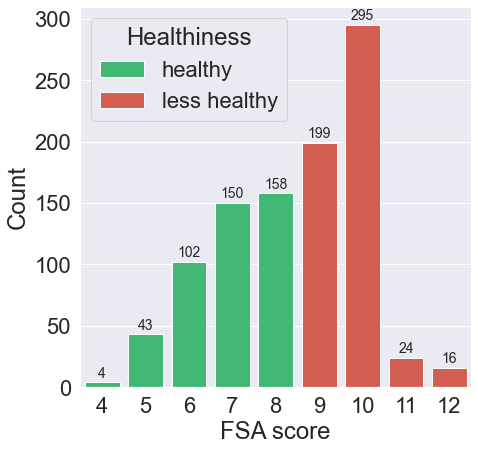

In [371]:
plt_data(fsa_dist, 'Fsa_dist','FSA score','Count',("#2ecc71","#e74c3c"),'Healthiness')

In [372]:
## Plot the NutriScore
Nutri_dist = prepare_Df(all_data.Nutri_score, 'Nutri score','Nutri distribution')
Nutri_dist

,Nutri score,Count,freq,Healthiness
0,A,234,0.236125,healthy
1,B,278,0.280525,healthy
2,C,298,0.300706,healthy
3,D,171,0.172553,healthy
4,E,10,0.010091,healthy


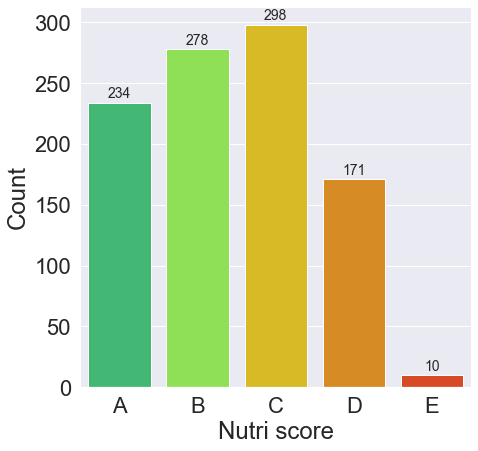

In [373]:

plt_data(Nutri_dist, 'Nutri_score','Nutri score','Count',("#2ecc71","#8BF541","#F5CE07","#F59007", "#F53907"))

In [374]:
## plot healhiness distribution 
healthy_dist = pd.read_csv('./healthiness_dist.csv')
healthy_dist.rename(columns={'healthiness':'Healthiness'}, inplace=True)
healthy_dist

,Healthiness,str_condition,Count
0,Healthy,MTL,58
1,Healthy,No label,61
2,Healthy,Nutri score,62
3,Less healthy,MTL,42
4,Less healthy,No label,39
5,Less healthy,Nutri score,38


In [392]:
def plt_healthiness(healthiness, title, hue=None, order=None, ax=None):
    plt.figure(figsize=(7, 7))
    #sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    splot = sns.barplot(data = healthiness, x = 'str_condition', y = 'Count', hue=hue, palette = ("#2ecc71","#e74c3c", ), order = order, ax=ax)#, legend = False)
    splot.set_xticklabels(splot.get_xticklabels(),rotation = 0)
    for p in splot.patches:
                print(p)
                splot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points', fontsize=14)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc=2, borderaxespad=0., title='Healthiness')

    # splot.axes.set_title("Title",fontsize=50)
    splot.set_xlabel("Condition")#,fontsize=12)
    # splot.set_ylabel("Count",fontsize=20)
    # splot.tick_params(labelsize=5)
    plt.savefig('./'+title+"_.png", bbox_inches='tight', dpi=300)

Rectangle(xy=(-0.4, 0), width=0.4, height=61, angle=0)
Rectangle(xy=(0.6, 0), width=0.4, height=62, angle=0)
Rectangle(xy=(1.6, 0), width=0.4, height=58, angle=0)
Rectangle(xy=(-2.77556e-17, 0), width=0.4, height=39, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=38, angle=0)
Rectangle(xy=(2, 0), width=0.4, height=42, angle=0)


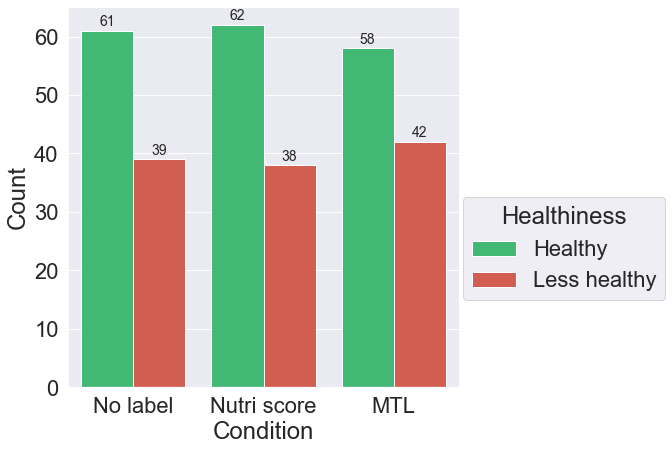

In [393]:
plt_healthiness(healthy_dist, 'HealthinessDistribution', hue='Healthiness', order=['No label','Nutri score','MTL'])

In [470]:
goal_dist

,number_of_dietgoals,str_condition,Count
0,0,MTL,23
1,0,No label,23
2,0,Nutri-score,25
3,1,MTL,28
4,1,No label,27
5,1,Nutri-score,33
6,2,MTL,24
7,2,No label,14
8,2,Nutri-score,16
9,3,MTL,17


In [474]:
## Plot goals per condition
goal_dist = pd.read_csv('./goals_dist.csv')
# plot goal distribution
goal_dist['max'] = [0,0,25,0,0,33,24,0,0,22,0,0,0,10,0,4,0,3,0,0]

def plt_goals(goals, title, hue=None, hue_order=None, order=None, ax=None):
    plt.subplots(figsize=(7,7))
    sns.set_style("darkgrid")#, {"grid.color": ".6", "grid.linestyle": ":"})
    splot = sns.barplot(data = goals, x = 'number_of_dietgoals', y = 'Count', hue=hue,  palette = ("#e74c3c", "#34495e", "#2ecc71"), capsize=.2 ,hue_order=hue_order,order = order, ax=ax)
    splot.set_xticklabels(splot.get_xticklabels(),rotation = 0)
    
    splot.set_xlabel("number of diet goals")#,fontsize=12)
    splot.set(ylim=(0, 40))
    #splot.legend_.remove()
    plt.legend(bbox_to_anchor=(1.01,0.5), loc=2, borderaxespad=0., title='Labels')

    plt.savefig('./'+title+"_.png", bbox_inches='tight', dpi=300)

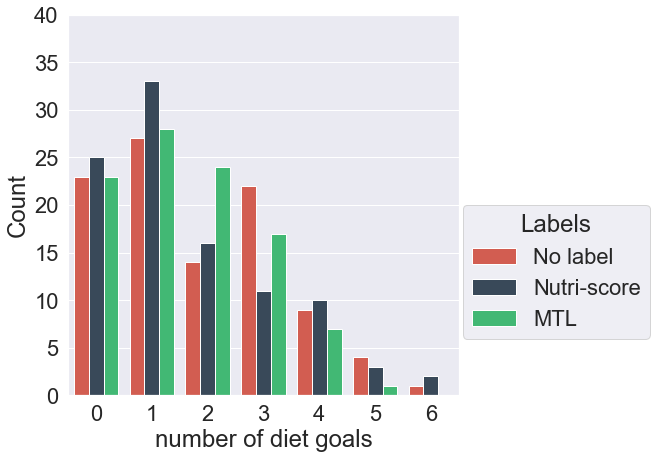

In [475]:
plt_goals(goal_dist, 'goals_condition', 'str_condition', hue_order=['No label','Nutri-score','MTL'])

In [498]:
## Fsa per goals
all_goalS = pd.read_csv('./ayoub_data_goals.csv')
fsa_per_goals = all_goalS.groupby('number_of_dietgoals')['fsa_score'].mean().reset_index(name='avgfsa')
fsa_per_goals

,number_of_dietgoals,avgfsa
0,0,8.619718
1,1,7.886364
2,2,8.537037
3,3,8.620000
4,4,8.423077
5,5,8.375000
6,6,7.333333


<AxesSubplot:xlabel='number_of_dietgoals', ylabel='avgfsa'>

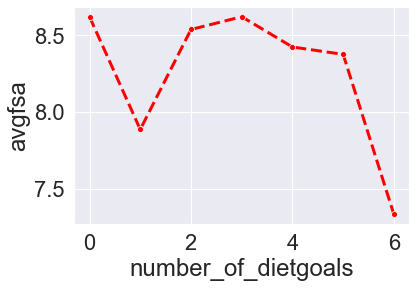

In [529]:
sns.lineplot(data = fsa_per_goals, x='number_of_dietgoals',y='avgfsa', marker="o", dashes=True, linestyle='--', linewidth = 3, color = 'red')
#sns.scatterplot(x = 'number_of_dietgoals', y = 'avgfsa', size = 'avgfsa', data = fsa_per_goals, color = 'red').legend_.remove()

In [556]:
Avg_muliple_goals = fsa_per_goals.loc[fsa_per_goals.number_of_dietgoals > 1]['avgfsa']
Avg_muliple_goals.mean()

8.257689458689459

In [535]:
## Plot goals per condition
# plot goal distribution
goal_dist['max'] = [0,0,25,0,0,33,24,0,0,22,0,0,0,10,0,4,0,3,0,0]

def plt_goals_both(goals, title, hue=None, hue_order=None, order=None, ax=None):
    fig, ax1 = plt.subplots(figsize=(10,6))
    #plt.subplots(figsize=(7,7))
    sns.set_style("darkgrid")#, {"grid.color": ".6", "grid.linestyle": ":"})
    #splot = 
    ax2 = sns.barplot(data = goals, x = 'number_of_dietgoals', y = 'Count', hue=hue,  palette = ("#e74c3c", "#34495e", "#2ecc71"), capsize=.2 ,hue_order=hue_order,order = order, ax=ax)
    ax2 = ax1.twinx()
    #splot.set_xticklabels(splot.get_xticklabels(),rotation = 0)
    ax2 = sns.lineplot(data = fsa_per_goals, x='number_of_dietgoals',y='avgfsa', marker="o", dashes=True, linestyle='--', linewidth = 3, color = 'red')
    # splot.set_xlabel("number of diet goals")#,fontsize=12)
    # splot.set(ylim=(0, 40))
    ax1.legend_.remove()
    #plt.legend(bbox_to_anchor=(1.01,0.5), loc=2, borderaxespad=0., title='Labels')

    plt.savefig('./'+title+"_.png", bbox_inches='tight', dpi=300)

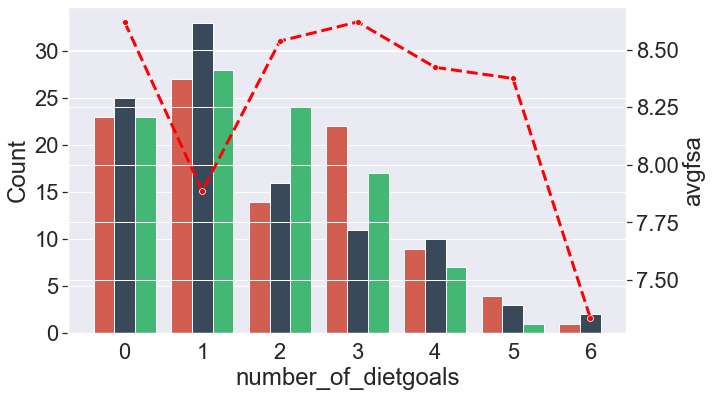

In [536]:
plt_goals_both(goal_dist, 'goals_condition', 'str_condition', hue_order=['No label','Nutri-score','MTL'])

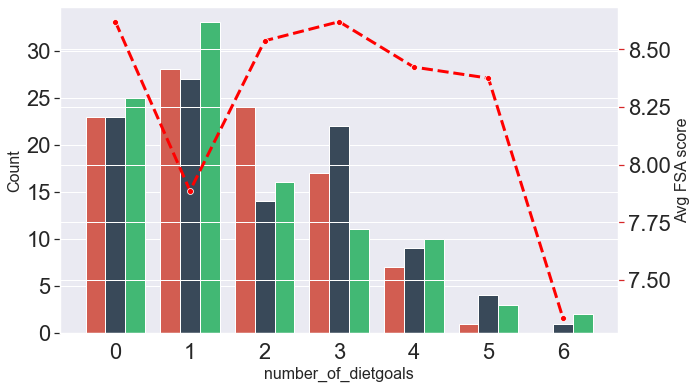

In [546]:
#Create combo chart

fig, ax1 = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
#bar plot creation
#ax1.set_title('Average Percipitation Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Avg Temp', fontsize=16)
ax1 = sns.barplot(data = goal_dist, x = 'number_of_dietgoals', y = 'Count', hue='str_condition',  palette = ("#e74c3c", "#34495e", "#2ecc71"), capsize=.2)# ,hue_order=hue_order,order = order, ax=ax)
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
ax1.legend_.remove()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Avg FSA score', fontsize=16)
# sns.set_style('white'
# )
ax2 = sns.lineplot(data = fsa_per_goals, x='number_of_dietgoals',y='avgfsa', marker="o", dashes=True, linestyle='--', linewidth = 3, color = 'red')
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

In [408]:
## Plot goals per condition
diet_goals = pd.read_csv('./all_goals.csv')
diet_goals.head()

,diet_goal,Count,freq,condition
0,Eat more fruit,44,21.359223,No label
1,Eat less sugar,40,21.052632,Nutri
2,Eat more vegetables,37,17.961165,No label
3,Eat more protein,36,17.475728,No label
4,Eat more vegetables,35,19.021739,MTL


In [552]:
def plt_diet_goal(diet_goal, title, palette,hue=None, order=None):
    plt.figure(figsize=(10, 10))
    sns.set_style("darkgrid")#, {"grid.color": ".6", "grid.linestyle": ":"})
    x = 'Count'
    y = 'diet_goal'
    if title == 'All':
        x,y = y,x
    splot = sns.barplot(data = diet_goal, x = x, y = y, hue=hue, palette = ("#e74c3c", "#34495e", "#2ecc71"), order = order)
    splot.set(xlabel= 'Diet goals', ylabel = 'Count')
    splot.legend_.remove()
    if title  == 'All':
        splot.set_xticklabels(splot.get_xticklabels(),rotation = 75)
    splot.set(ylabel='Count')
    plt.savefig('./'+title+"_diet_goal.png", bbox_inches='tight', dpi=300)

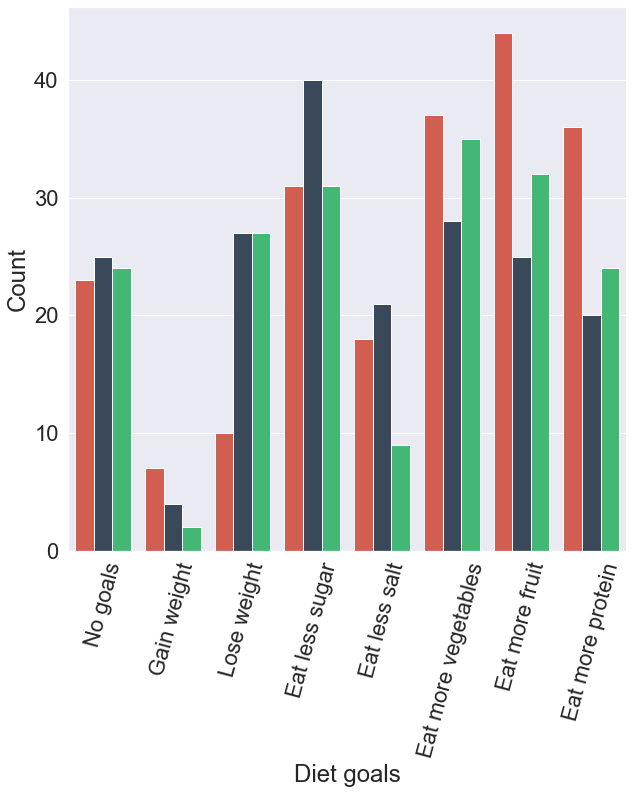

In [553]:
order  = ['No goals','Gain weight','Lose weight','Eat less sugar','Eat less salt','Eat more vegetables','Eat more fruit','Eat more protein']
plt_diet_goal(diet_goals, 'All','ocean_r','condition', order=order)